In [2]:
%pylab inline
from autometacal.python.datasets import CFIS
import tensorflow_datasets as tfds
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


## Loading the data

The CFIS dataset includes simulated galaxies under simplistic CFIS-like
observing conditions.

In [21]:
# We create a function to add noise on the fly for data augmentation
@tf.function
def add_noise(example):
    im_noise = example['obs'] + example['noise_std'] * tf.random.normal([51,51])
    return im_noise, example

dset = tfds.load('CFIS/parametric_shear_1k', split='train')
dset = dset.map(add_noise)

In [22]:
# Use ngmix to check these galaxies out
import ngmix
fitter = ngmix.gaussmom.GaussMom(fwhm=1.2)
s2n = []
mag = []
for im, example in dset:
    wt = np.zeros_like(im) + 1.0/example['noise_std']**2
    obs = ngmix.Observation(im.numpy(),
                            jacobian=ngmix.DiagonalJacobian(row=51/2, 
                                                            col=51/2, 
                                                            scale=0.187),
                             weight=wt)
    res = fitter.go(obs)
    s2n.append(res['s2n'])
    mag.append(example['mag'].numpy().squeeze())
s2n = np.stack(s2n)
mag = np.stack(mag)

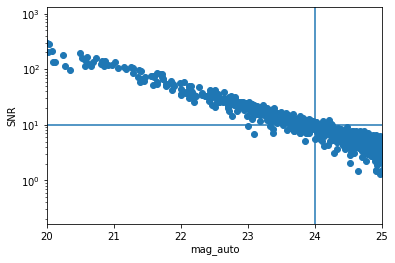

In [23]:
scatter(mag,s2n)
xlim(20,25)
yscale('log')
axvline(24.)
axhline(10.)
xlabel('mag_auto')
ylabel('SNR');

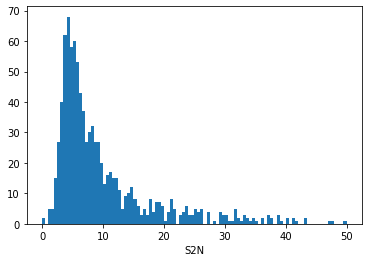

In [26]:
hist(s2n,100,range=[0,50]);
xlabel('S2N');

## Testing calibration bias with ngmix and autometacal

In [56]:
# We will measure moments with a fixed gaussian weight function
weight_fwhm = 1.2
fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
# these "runners" run the measurement code on observations
psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
runner = ngmix.runners.Runner(fitter=fitter)


rng = np.random.RandomState(31415)
    
boot = ngmix.metacal.MetacalBootstrapper(
    runner=runner, psf_runner=psf_runner,
    rng=rng,
    psf='gauss',
    types=['noshear', '1p', '1m'],
    fixnoise=True,
)

def select(data, shear_type):
    """
    select the data by shear type and size
    Parameters
    ----------
    data: array
        The array with fields shear_type and T
    shear_type: str
        e.g. 'noshear', '1p', etc.
    Returns
    -------
    array of indices
    """

    w, = np.where(
        (data['flags'] == 0) & (data['shear_type'] == shear_type)
    )
    return w


def make_struct(res, obs, shear_type):
    """
    make the data structure
    Parameters
    ----------
    res: dict
        With keys 's2n', 'e', and 'T'
    obs: ngmix.Observation
        The observation for this shear type
    shear_type: str
        The shear type
    Returns
    -------
    1-element array with fields
    """
    dt = [
        ('flags', 'i4'),
        ('shear_type', 'U7'),
        ('s2n', 'f8'),
        ('g', 'f8', 2),
        ('T', 'f8'),
        ('Tpsf', 'f8'),
    ]
    data = np.zeros(1, dtype=dt)
    data['shear_type'] = shear_type

    if max(abs(res['e'])) > 5:
        res['flags'] = -1
        
    data['flags'] = res['flags']
        
    if res['flags'] == 0:
        data['s2n'] = res['s2n']
        # for moments we are actually measureing e, the elliptity
        data['g'] = res['e']
        data['T'] = res['T']
    else:
        data['s2n'] = np.nan
        data['g'] = np.nan
        data['T'] = np.nan
        data['Tpsf'] = np.nan

        # we only have one epoch and band, so we can get the psf T from the
        # observation rather than averaging over epochs/bands
        data['Tpsf'] = obs.psf.meta['result']['T']

    return data

In [57]:
from tqdm import tqdm
dlist = []

jacobian = ngmix.DiagonalJacobian(row=51/2, col=51/2, scale=0.187)

for im, example in tqdm(dset):
    wt = np.zeros_like(im) + 1.0/example['noise_std']**2

    psf_obs = ngmix.Observation(
        example['psf'].numpy(),
        jacobian=jacobian,
    )
    
    obs = ngmix.Observation(im.numpy(),
                            jacobian=jacobian,
                            psf=psf_obs,
                            weight=wt)   
    
    resdict, obsdict = boot.go(obs)
    
    for stype, sres in resdict.items():
        st = make_struct(res=sres, obs=obsdict[stype], shear_type=stype)
        dlist.append(st)

data = np.hstack(dlist)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:46<00:00, 21.70it/s]


In [58]:
w = select(data=data, shear_type='noshear')
w_1p = select(data=data, shear_type='1p')
w_1m = select(data=data, shear_type='1m')

g = data['g'][w].mean(axis=0)
gerr = data['g'][w].std(axis=0) / np.sqrt(w.size)
g1_1p = data['g'][w_1p, 0].mean()
g1_1m = data['g'][w_1m, 0].mean()
R11 = (g1_1p - g1_1m)/0.02

shear = g / R11
shear_err = gerr / R11
m = shear[0] / 0.02 - 1
merr = shear_err[0]/0.02
s2n = data['s2n'][w].mean()

In [59]:
print('ngmix results:')
print('S/N: %g' % s2n)
print('R11: %g' % R11)
print('m: %g +/- %g (99.7%% conf)' % (m, merr*3))
print('c: %g +/- %g (99.7%% conf)' % (shear[1], shear_err[1]*3))

ngmix results:
S/N: 17.1349
R11: 0.390659
m: -0.995659 +/- 5.53101 (99.7% conf)
c: 0.0575897 +/- 0.107426 (99.7% conf)


In [75]:
# saving the reconv psf
reconv_psf = tf.convert_to_tensor(obsdict['noshear'].psf.image.reshape([1,51,51]).repeat(100,axis=0).astype('float32'))

#### Now doing the same thing with autometacal

In [79]:
import autometacal 

@tf.function
def get_autometacal_shape(im, example):
    method = lambda x: autometacal.get_moment_ellipticities(x, scale=0.187, fwhm=weight_fwhm)
    return autometacal.get_metacal_response(im, example['psf'], reconv_psf, method)

In [80]:
dset = tfds.load('CFIS/parametric_shear_1k', split='train')
dset = dset.map(add_noise)
dset = dset.batch(100)

In [81]:
res_e = []
res_R = []
for im, example in tqdm(dset):
    e, R = get_autometacal_shape(im, example)
    res_e.append(e)
    res_R.append(R)
res_e = np.concatenate(res_e)
res_R = np.concatenate(res_R)

  0%|                                                                                                                                                           | 0/10 [00:00<?, ?it/s]2021-11-07 02:52:20.246844: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-07 02:52:20.246874: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


 10%|██████████████▋                                                                                                                                    | 1/10 [00:04<00:38,  4.32s/it]

 20%|█████████████████████████████▍                                                                                                                     | 2/10 [00:08<00:33,  4.15s/it]

 30%|████████████████████████████████████████████                                                                                                       | 3/10 [00:12<00:28,  4.02s/it]

 40%|██████████████████████████████████████████████████████████▊                                                                                        | 4/10 [00:16<00:23,  3.97s/it]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 5/10 [00:20<00:20,  4.11s/it]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 6/10 [00:24<00:16,  4.19s/it]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 7/10 [00:28<00:12,  4.17s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 8/10 [00:33<00:08,  4.29s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 9/10 [00:37<00:04,  4.34s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.23s/it]


In [111]:
m = np.max(abs(res_e),axis=1) < 5
auto_g = res_e[m].mean(axis=0)
auto_R = res_R[m].mean(axis=0)

In [112]:
auto_gerr = res_e[m].std(axis=0) / np.sqrt(res_e[m].size)
auto_shear = auto_g / auto_R[0,0]
auto_shear_err = auto_gerr / auto_R[0,0]
auto_m = auto_shear[0] / 0.02 - 1
auto_merr = auto_shear_err[0]/0.02

In [113]:
print('autometacal results:')
print('R11: %g' % auto_R[0,0])
print('m: %g +/- %g (99.7%% conf)' % (auto_m, auto_merr*3))
print('c: %g +/- %g (99.7%% conf)' % (auto_shear[1], auto_shear_err[1]*3))

autometacal results:
R11: 0.141655
m: 0.0708357 +/- 4.65925 (99.7% conf)
c: 0.0845241 +/- 0.108777 (99.7% conf)
